# calculate longitudinal coherence between two lidar range gates

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.special as sp

#from tqdm import tqdm_notebook as tqdm


In [2]:
# %matplotlib inline
# %matplotlib
#tqdm().pandas()

## Parameters

In [20]:
# longitudinal coherence parameters
a1 = 8.4
a2 = 0.05
b1 = 0.25
b2 = 1.24

# wind parameters
U = 11.5
sigma = 0.71
L = 550

# range gate separation distance
d = 36
# pulsed lidar parameters
delp = 18.
delr = 49.8/2

# frequencies to analyze
fs = np.arange(0,0.5,0.01)

## Define longitudinal coherence and lidar range weighting functions

In [22]:
def long_coh(fs,d,U,sigma,L,a1=8.4,a2=0.05,b1=0.25,b2=1.24):
    a = a1*sigma/U + a2
    b = b1*L**-b2
    return np.exp(-a*np.sqrt((fs*d/U)**2 + (b*d)**2))

In [23]:
def range_weight(delp,delr,res=1.,cutoff=0.01):
    rp = delr/(2*np.sqrt(np.log(2)))
    
    wts = np.array([(1/(2*delp))*(sp.erf((delp/2)/rp) - sp.erf((-delp/2)/rp))])
    wt = wts[0]
    wt0 = wt
    
    r = res
    while wt/wt0 > cutoff:
        wt = (1/(2*delp))*(sp.erf((r+delp/2)/rp) - sp.erf((r-delp/2)/rp))
        wts = np.append(np.append(wt,wts),wt)
        r = r + res
    
    wts = wts/np.sum(wts)
    
    return wts

## Calculate coherence between range gates

In [24]:
res = 1
wts = range_weight(delp,delr,res,0.01)
xs = np.arange(-(len(wts)-1)*res/2,(len(wts)-1)*res/2+res,res)

S_LL = np.zeros(len(fs))
S_L1L2 = np.zeros(len(fs))

# not including PSDs since they will cancel out in final coherence equation

for i in range(len(xs)-1):
    for k in range(len(xs)-1):
        S_LL = S_LL + wts[i]*wts[k]*np.sqrt(long_coh(fs,np.abs(xs[k]-xs[i]),U,sigma,L,a1=a1,a2=a2,b1=b1,b2=b2))*np.exp(1j*2*np.pi*(xs[k]-xs[i])*fs/U)
        S_L1L2 = S_L1L2 + wts[i]*wts[k]*np.sqrt(long_coh(fs,np.abs(d+xs[k]-xs[i]),U,sigma,L,a1=a1,a2=a2,b1=b1,b2=b2))*np.exp(1j*2*np.pi*(d+xs[k]-xs[i])*fs/U)
        
Coh_L1L2 = (np.absolute(S_L1L2)**2)/(np.absolute(S_LL)**2)  

## plot original and lidar measured coherence

Text(0.5, 0, 'Frequency (Hz)')

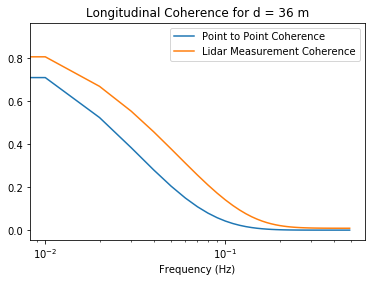

In [25]:
Coh_x1x2 = long_coh(fs,d,U,sigma,L,a1=a1,a2=a2,b1=b1,b2=b2)

plt.figure()
plt.plot(fs,Coh_x1x2,label='Point to Point Coherence')
plt.plot(fs,Coh_L1L2,label='Lidar Measurement Coherence')
plt.xscale('log')
plt.legend()
plt.title('Longitudinal Coherence for d = '+str(d)+' m')
plt.xlabel('Frequency (Hz)')

# fig,axs = plt.subplots(2,1,sharex=True)

# axs[0].plot(fs,np.absolute(H))
# axs[0].scatter(fs[i],np.absolute(H[i]))
# axs[0].set_ylabel('Magnitude (-)')
# axs[0].set_xscale('log')
# axs[1].plot(fs,np.degrees(np.angle(H))/(360*fs))
# axs[1].scatter(fs[i],np.degrees(np.angle(H[i]))/(360*fs[i]))
# axs[1].set_xlabel('Frequency (Hz)')
# axs[1].set_ylabel('Time lag (s)')
# axs[1].set_xscale('log')